In [277]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob

In [199]:
models = ['GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'BirdFlowGraphLSTM']
results = dict()
base_dir = '/home/fiona/birdMigration/results/radar/testing'
for m in models:
    experiment = 'best_config'
    model_dir = f'{base_dir}/{m}/{experiment}'
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])

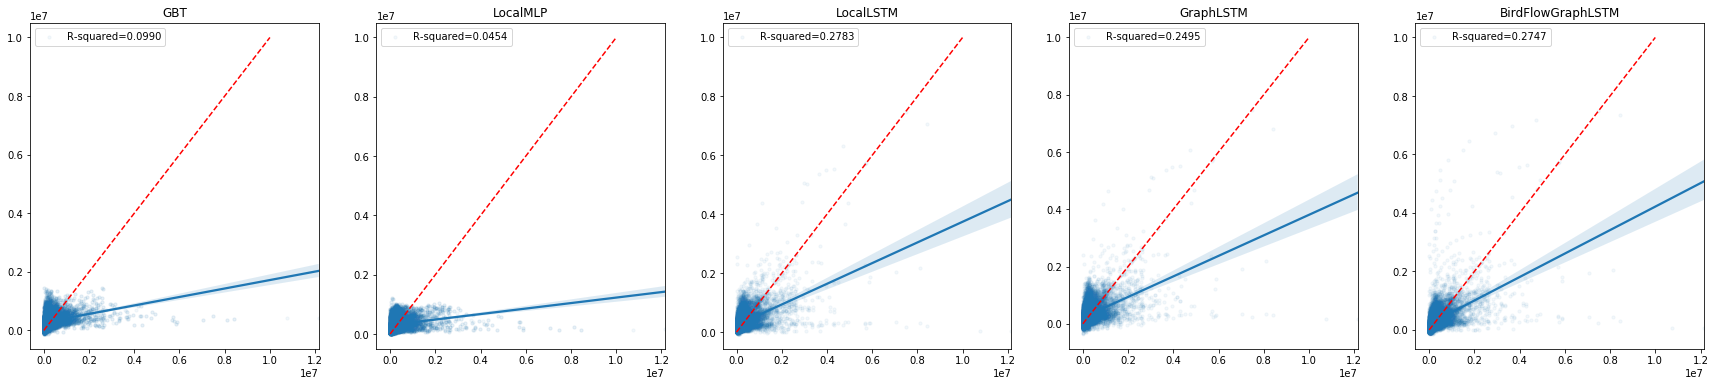

In [294]:
model = 'BirdFlowGraphLSTM'
#model = 'LocalMLP'
#model = 'GBT'

lb = 25
use_log = False

fig, ax = plt.subplots(1, len(models), figsize=(len(models)*6,6))
for midx, m in enumerate(models):
    gt = results[m]['gt'].replace(0, np.nan).values
    mask = np.isfinite(gt) & (gt > lb)
    gt = gt[mask]
    if use_log: gt = np.log(gt)
    
    pred = results[m]['prediction'].replace(0, np.nan).values
    pred = pred[mask]
    if use_log: pred = np.log(np.maximum(pred, lb))
    
    #ax[midx].scatter(gt, pred, alpha=0.05)
    res = sp.stats.linregress(gt, pred)
    sb.regplot(gt, pred, scatter=True, ci=95, ax=ax[midx], label=f'R-squared={res.rvalue**2:.4f}', scatter_kws={'alpha':0.05, 's':10})

    if use_log:
        ax[midx].plot(np.log([lb,1e7]), np.log([lb, 1e7]), ls='--', c='red')
    else:
        ax[midx].plot([lb,1e7], [lb, 1e7], ls='--', c='red')
    #ax[midx].set_xlim(50, 1e7)
    #ax[midx].set_ylim(50, 1e7)
    #ax[midx].set(yscale='symlog', xscale='symlog')
    ax[midx].legend()
    ax[midx].set_title(m)

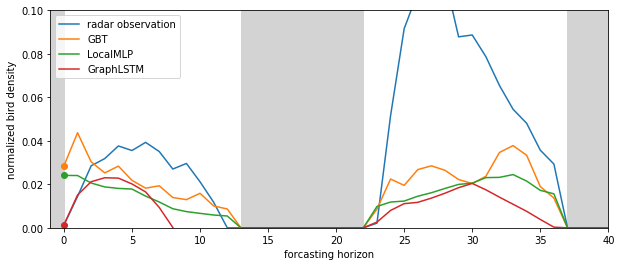

In [263]:
sid = 1
radar = 'deoft'
trial = 0

fig, ax = plt.subplots(figsize=(10, 4))
for i, m in enumerate(['GBT', 'LocalMLP', 'GraphLSTM']):
    r = results[m].query(f'seqID == {sid} & radar == "{radar}" & trial == {trial}')
    if i==0:
        ax.plot(range(len(r)), r['gt']/bird_scale, label='radar observation')
    line = ax.plot(range(len(r)), r['prediction']/bird_scale * r['night'], label=m)
    ax.plot(0, r['prediction'].iloc[0]/bird_scale, 'o', c=line[0].get_color())
    
ax.fill_between(range(13, 23), 0, 0.1, color='lightgray')
ax.fill_between(range(-1, 1), 0, 0.1, color='lightgray')
ax.fill_between(range(37, 41), 0, 0.1, color='lightgray')
ax.set(ylim=(0, 0.1), xlim=(-1, 40), xlabel='forcasting horizon', ylabel='normalized bird density')
plt.legend()
#fig.savefig('/home/fiona/birdMigration/data/plots/presentations/example_forecast.png', bbox_inches='tight', dpi=300)

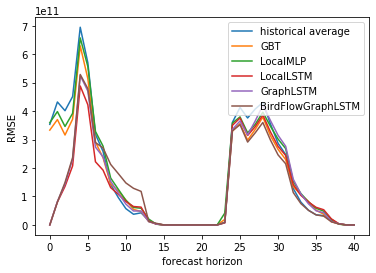

In [264]:
fig, ax = plt.subplots()

for idx, m in enumerate(models):
    if idx == 0:
        constant_prediction = results[m].groupby('radar')['gt'].aggregate(np.mean)
        results[m]['constant_error'] = results[m].apply(lambda row: (row['gt'] - constant_prediction.loc[row.radar] * row.night)**2, axis=1)
        mse_const = results[m].groupby(['horizon', 'trial']).constant_error.mean() #.apply(np.sqrt)
        mean_mse_c = mse_const.groupby('horizon').aggregate(np.mean)
        ax.plot(mean_mse_c, label='historical average')
    
    results[m]['error'] = results[m].apply(lambda row: (row['gt'] - row['prediction'] * row.night)**2, axis=1)
    mse = results[m].groupby(['horizon', 'trial']).error.mean() #.apply(np.sqrt)
    mean_mse = mse.groupby('horizon').aggregate(np.mean)
    std_mse = mse.groupby('horizon').aggregate(np.std)
    
    l = ax.plot(mean_mse, label=m)
    ax.fill_between(mean_mse.index, mean_mse+std_mse, mean_mse-std_mse, alpha=0.2, color=l[0].get_color())
    
plt.legend()
ax.set(xlabel='forecast horizon', ylabel='RMSE');

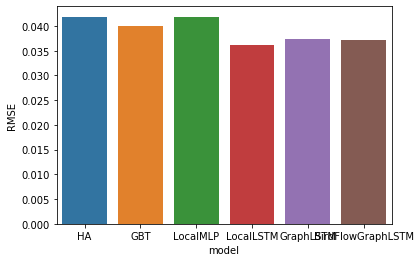

In [217]:
fig, ax = plt.subplots()
rmse_list = []
labels = []
bird_scale = 9938497.9440479
for idx, m in enumerate(models):
    if idx == 0:
        constant_prediction = results[m].groupby('radar')['gt'].aggregate(np.mean)
        results[m]['constant_error'] = results[m].apply(lambda row: ((row['gt'] - constant_prediction.loc[row.radar] * row.night)/bird_scale)**2, axis=1)
        mse_const = np.sqrt(results[m].constant_error.mean())
        rmse_list.append(mse_const)
        labels.append('HA')
    
    rmse_list.append(np.sqrt(results[m].apply(lambda row: ((row['gt'] - row['prediction'] * row.night)/bird_scale)**2, axis=1).mean()))
    labels.append(m)
    
df = pd.DataFrame(dict(RMSE=rmse_list, model=labels))
sb.barplot(x='model', y='RMSE', data=df)
ax.set(ylabel='RMSE');

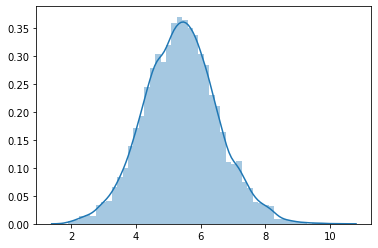

In [302]:
sb.distplot(np.power(gt, 1/7))

In [304]:
df = pd.read_csv('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/dynamic_features.csv')

In [305]:
df.columns

Index(['Unnamed: 0', 'birds', 'birds_from_buffer', 'radar', 'solarpos_dt',
       'solarpos', 'night', 'dusk', 'dawn', 'datetime', 'dayofyear', 'tidx',
       'u', 'v', 'cc', 'tp', 'sp', 't2m', 'sshf', 'wind_speed', 'wind_dir',
       'nightID', 'acc_rain', 'acc_wind', 'wind_profit'],
      dtype='object')

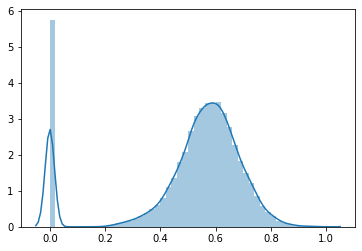

In [361]:
col = 'birds'
data = np.power(df[col][df.night].values, 1/7.5)
data_scaled = data / np.nanmax(data)
sb.distplot(data_scaled)
#sb.distplot(np.log(df[col].values + 0.0001))
#sb.distplot(df[col][df[col]>0].values)
#np.nanmax(np.power(df[col][df.night].values, 1/7))

In [338]:
np.power(0, 1/5)

0.0

(-6.123561718243683e-18, 1.0)

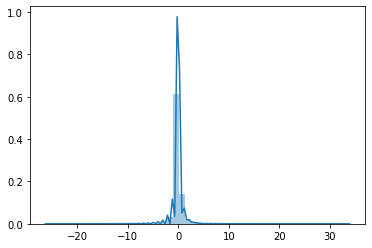

In [351]:
diff = df['birds'][df.night].values[1:] - df['birds'][df.night].values[:-1]
#sb.distplot(diff)
m = np.nanmean(diff)
s = np.nanstd(diff)
diff_s = (diff-m)/s
sb.distplot(diff_s)
np.nanmean(diff_s), np.nanstd(diff_s)

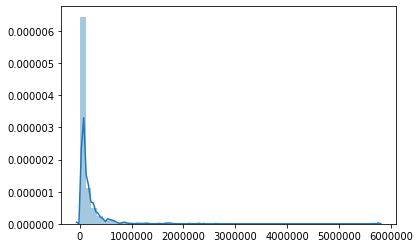

In [349]:
sb.distplot(df['birds'].values[1:][df.night.values[1:] & ~df.night.values[:-1]])